![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Medical_Language_Models/April_2025/Notebooks/Dicom_Deidentification_Using_Metadata.ipynb)

<!-- ========================================================= -->
<!--        John Snow Labs - Package Installation Guide         -->
<!--        JupyterLab Single Markdown Cell (HTML Content)      -->
<!-- ========================================================= -->

<h1>Package Installation</h1>

<!-- Link to official GitHub repository -->
<p>
  Official Repository:
  <a href="https://github.com/JohnSnowLabs/johnsnowlabs" target="_blank">
    https://github.com/JohnSnowLabs/johnsnowlabs
  </a>
</p>

<!-- License setup instructions -->
<p>
  Keep your <strong>license keys</strong> in a JSON file and point to it using the
  <code>json_license_path</code> argument when starting the Spark session.
</p>

<!-- Visual NLP configuration note -->
<p>
  Set <code>visual=True</code> while starting the Spark session to install and make
  <strong>Visual NLP libraries</strong> available.
</p>

<!-- Restart note -->
<p>
  ⚠️ <strong>Important:</strong> After installing the library, make sure to
  <strong>RESTART your session</strong> before running Spark again.
</p>

<!-- End of notebook cell -->

In [ ]:
!pip install -q johnsnowlabs

In [ ]:
from johnsnowlabs import nlp, visual, medical

nlp.install(refresh_install=True, visual=True, json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

In [ ]:
### RESTART SESSION !!!

In [1]:
from johnsnowlabs import visual, nlp

spark = nlp.start(visual=True, hardware_target="gpu", json_license_path="./spark_nlp_for_healthcare_spark_ocr_10538.json")

spark

👌 License info detected in file ./spark_nlp_for_healthcare_spark_ocr_10538.json


25/10/21 11:17:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


👌 Launched gpu optimized session with with: 🚀Spark-NLP==6.1.3, 💊Spark-Healthcare==6.1.1, 🕶Spark-OCR==6.1.0, running on ⚡ PySpark==3.4.0


<h1>Dicom Pixel DeIdentification Using Metadata</h1>

<!-- Notebook purpose -->
<p>
  This notebook demonstrates <strong>pixel-level de-identification</strong> in DICOM images by combining insights from
  both <strong>DICOM metadata tags</strong> (such as Patient Name, Date of Birth, and other identifiers)
  and <strong>Named Entity Recognition (NER)</strong> outputs. The metadata-derived entities are used as
  contextual signals and merged with NER predictions from multiple sources to accurately locate and remove
  sensitive information embedded within image pixels, ensuring comprehensive PHI redaction across both metadata
  and visual content.
</p>

<!-- Stages list -->
<h2>Concepts and Components Covered in this Notebook</h2>
<ul>
    <li>DicomToMetadata</li>
    <li>DicomToImageV3</li>
    <li>ImageTextDetector</li>
    <li>ImageToTextV3</li>
    <li>DicomDeidentifier</li>
    <li>PositionFinder</li>
    <li>ImageDrawRegions</li>
    <li>DicomDeidentifier</li>
    <li>DocumentAssembler</li>
    <li>SentenceDetectorDLModel</li>
    <li>Tokenizer</li>
    <li>WordEmbeddingsModel</li>
    <li>MedicalNerModel</li>
    <li>NerConverterInternal</li>
    <li>ChunkMergeApproach</li>
</ul>

In [2]:
# 📦 Spark OCR Imports
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.schemas import BinarySchema

# ⚡ Spark NLP Core
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline

# 🔗 Spark ML
from pyspark.ml import Pipeline, PipelineModel
import pyspark.sql.functions as F

# 🧩 Spark NLP for Healthcare (JSL)
import sparknlp_jsl
from sparknlp_jsl.annotator import *
from sparkocr.base import LightPipeline

from pyspark.sql.functions import *
from pyspark.sql.types import *
from urllib.parse import urlparse
from IPython.display import display, Markdown
from PIL import Image, ImageDraw, ImageFont
import pkg_resources
import pandas as pd
import time

In [3]:
dicom_to_metadata = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata") \
    .setKeepInput(True)

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setLinkThreshold(0.5) \
    .setSizeThreshold(1) \
    .setUseGPU(False) \
    .setWidth(0) \
    .setHeight(0)

ocr = ImageToTextV3() \
    .setInputCols(["image_raw", "text_regions"]) \
    .setOutputCol("text")

deidentifier = DicomDeidentifier() \
    .setInputCols(["positions", "metadata"]) \
    .setOutputCol("entity") \
    .setKeepInput(True) \
    .setBlackList(["acc"])

position_finder = PositionFinder() \
    .setInputCols("entity") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setIgnoreSchema(True)

stages = [
    dicom_to_metadata,
    dicom_to_image,
    text_detector,
    ocr,
    deidentifier,
    position_finder,
]

dicom_pipe = Pipeline(stages=stages)

image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB


25/10/21 11:18:01 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
25/10/21 11:18:01 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


Download done! Loading the resource.


In [4]:
stages

[DicomToMetadata_84741f6e8d18,
 DicomToImageV3_221fda3a9040,
 ImageTextDetectorCraft_c378eb88af4b,
 ImageToTextV3_ec7ec872146b,
 DicomDeidentifier_80b01638924d,
 PositionFinder_ca26178bfadb]

<h3>Load a Single Dicom File and Extract Results</h3>

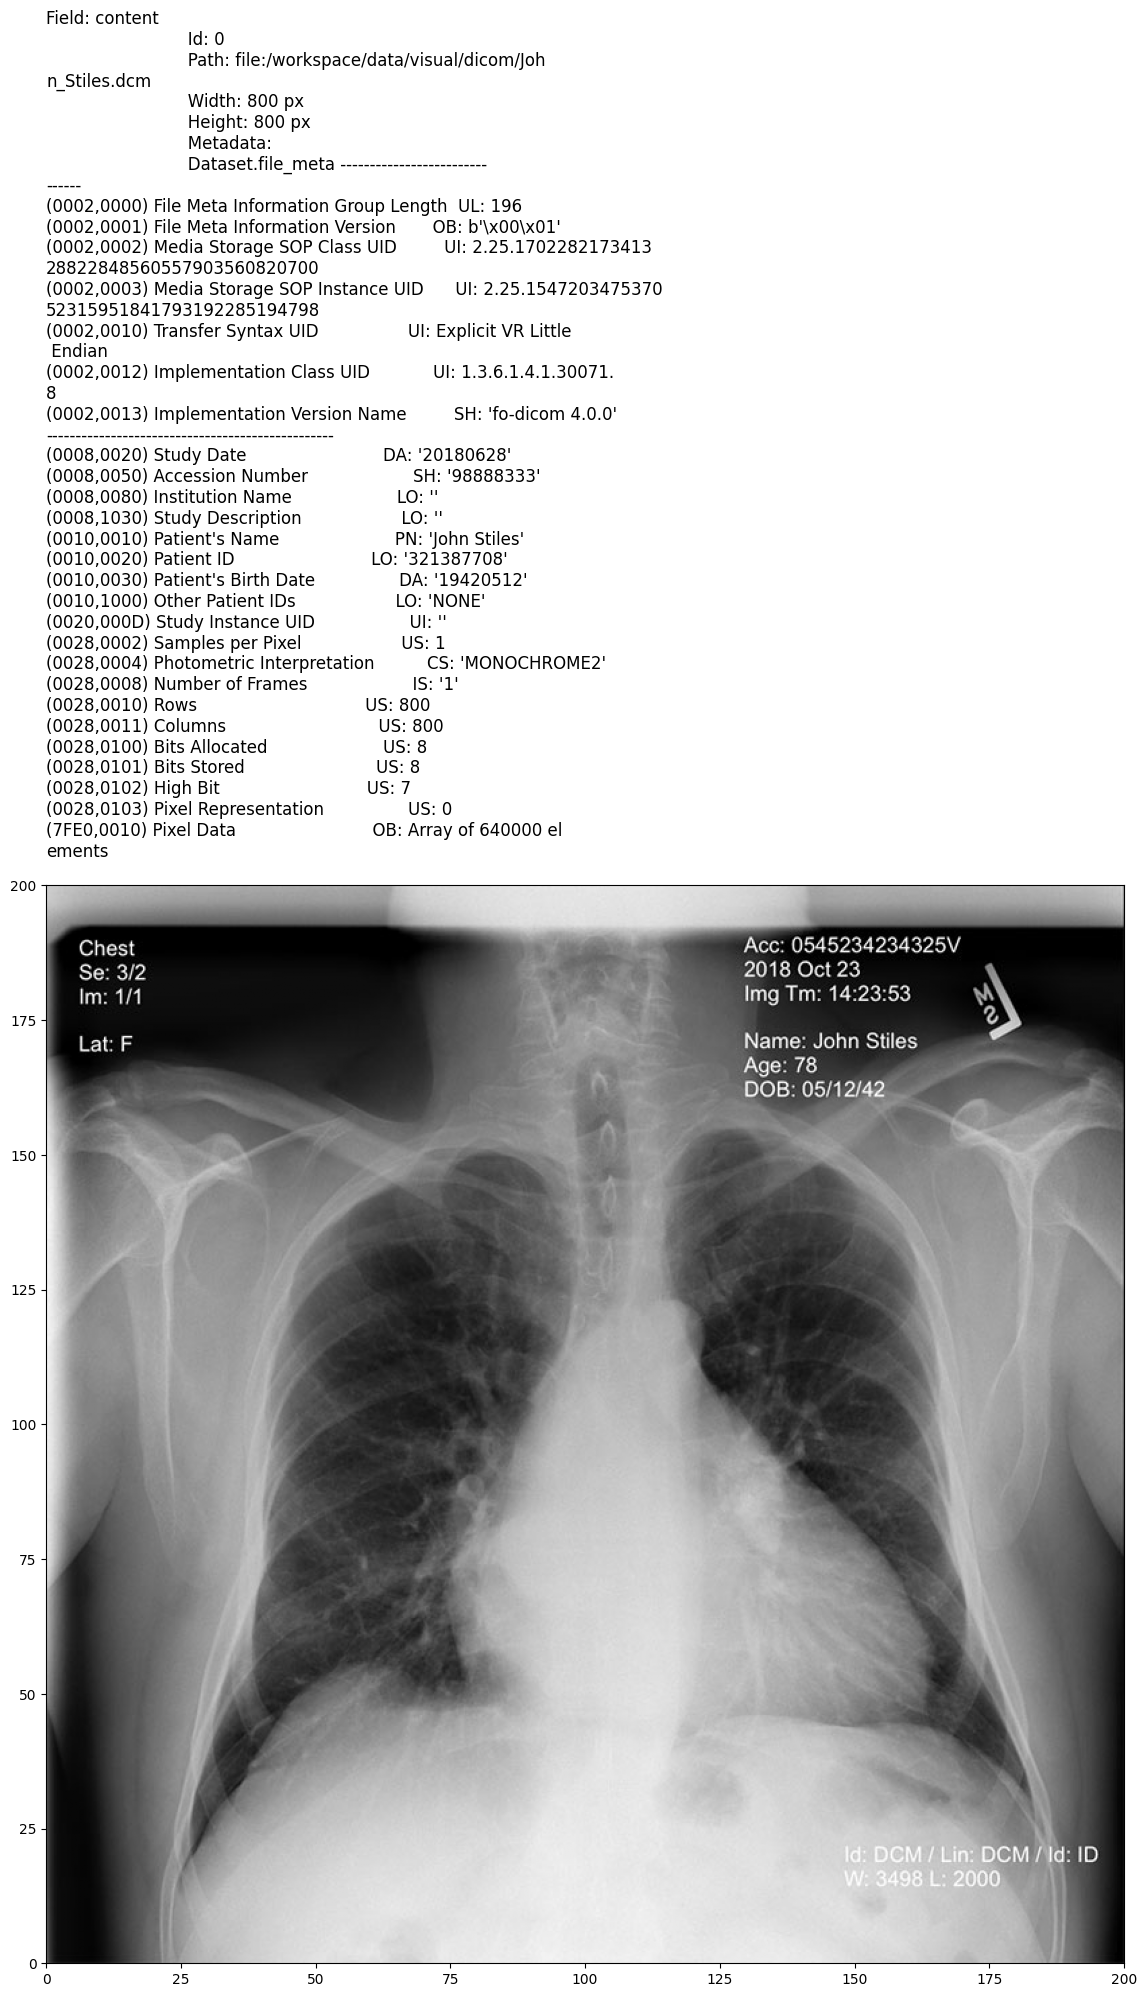

In [5]:
df = spark.read.format("binaryFile").load("./data/visual/dicom/John_Stiles.dcm")

display_dicom(df, "content")

In [6]:
result = dicom_pipe.fit(df).transform(df).cache()

result.columns

['entity',
 'exception',
 'image_raw',
 'pagenum',
 'path',
 'modificationTime',
 'length',
 'content',
 'text_regions',
 'text',
 'positions',
 'coordinates']

<h3>Visualization of Detected Text Regions</h3>

In [7]:
result.select(F.explode("text_regions").alias("detected_regions")).show(50, False)

/usr/local/lib/python3.12/dist-packages/sparkocr/transformers/dicom/dicom_metadata_deidentifier.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/usr/local/lib/python3.12/dist-packages/sparkocr/transformers/dicom/dicom_metadata_deidentifier.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
11:18:54, INFO Run DicomToImageV3
11:18:54, INFO DicomToImageV3: Number of frames: 1
11:18:54, INFO Error during overlay extraction: Traceback (most recent call last):
File "/usr/local/lib/python3.12/dist-packages/sparkocr/transformers/dicom/dicom_to_image_v3.py", l

+----------------------------------------------------------------------------+
|detected_regions                                                            |
+----------------------------------------------------------------------------+
|{0, 0, 597.0, 44.0, 16.0, 166.0, 0.99607843, 0, 90.0, true}                 |
|{0, 0, 46.0, 47.0, 14.0, 44.0, 0.99215686, 0, 90.0, true}                   |
|{0, 0, 561.0, 63.0, 14.0, 90.0, 0.99607843, 0, 90.0, true}                  |
|{0, 0, 48.0, 65.0, 18.0, 56.0, 0.9019608, 0, 90.0, true}                    |
|{0, 0, 579.0, 81.0, 18.0, 130.0, 0.9529412, 0, 90.0, true}                  |
|{0, 0, 699.0, 89.0, 34.0, 22.0, 0.90588236, 0, 90.0, true}                  |
|{0, 0, 49.0, 83.0, 14.0, 50.0, 0.81960785, 0, 90.0, true}                   |
|{0, 0, 582.0, 115.0, 18.0, 136.0, 0.99215686, 0, 90.0, true}                |
|{0, 0, 43.0, 118.0, 16.0, 46.0, 0.89411765, 0, 90.0, true}                  |
|{0, 0, 546.0, 137.0, 18.0, 60.0, 0.91764706, 0, 90.


    Image #0:
    Origin: file:/workspace/data/visual/dicom/John_Stiles.dcm
    Resolution: 0 dpi
    Width: 800 px
    Height: 800 px
    Mode: 10
    Number of channels: 1


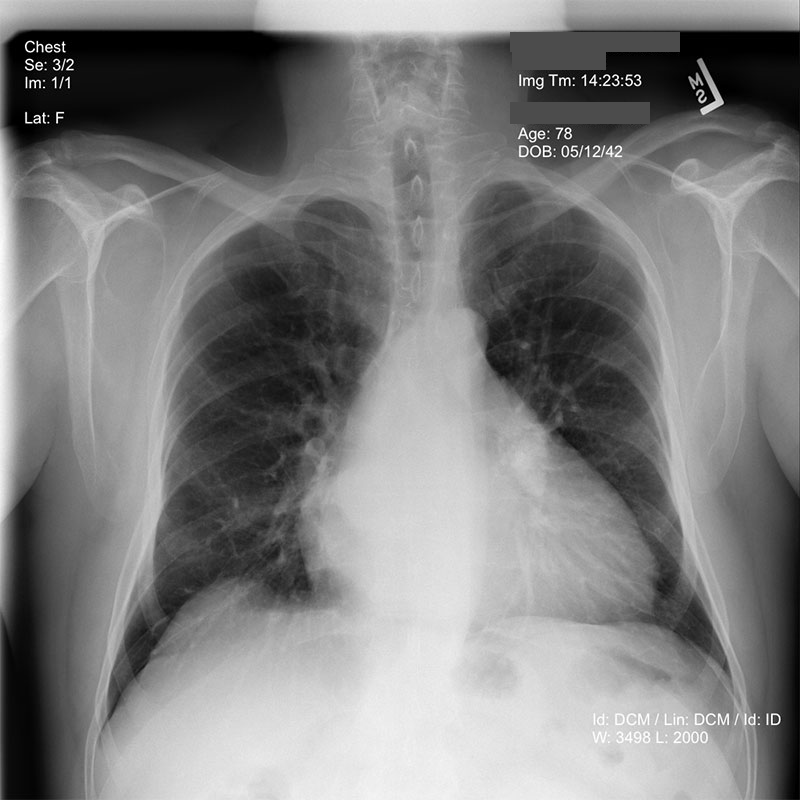

In [8]:
draw = ImageDrawRegions() \
  .setInputCol("image_raw") \
  .setInputRegionsCol("coordinates") \
  .setRectColor(Color.red) \
  .setOutputCol("image_with_regions") \
  .setFilledRect(True)

display_images(draw.transform(result), "image_with_regions")

<h3>View the NER's detected Using Metadata</h3>

In [9]:
# View the detected regions
result.select(F.explode("entity").alias("Metadata NER")).show(50, False)

+---------------------------------------------------+
|Metadata NER                                       |
+---------------------------------------------------+
|{named_entity, 0, 20, “Acc: 0545234234325V, {}, []}|
|{named_entity, 27, 38, 2018 Oct 23, {}, []}        |
|{named_entity, 75, 92, Name: John Stiles, {}, []}  |
+---------------------------------------------------+



<h3>Combining <strong>DicomDeidentifier</strong> with other NER Stages from Healthcare-NLP</h3>

In [ ]:
dicom_to_metadata = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata") \
    .setKeepInput(True)

dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(True) \
    .setTextThreshold(0.4) \
    .setLinkThreshold(0.5) \
    .setSizeThreshold(1) \
    .setUseGPU(False) \
    .setWidth(0) \
    .setHeight(0)

ocr = ImageToTextV3() \
    .setInputCols(["image_raw", "text_regions"]) \
    .setOutputCol("text")

deidentifier = DicomDeidentifier() \
    .setInputCols(["positions", "metadata"]) \
    .setOutputCol("entity") \
    .setKeepInput(True) \
    .setBlackList(["acc"])

document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document") \
    .setCleanupMode("disabled")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
      .setInputCols(['sentence', 'token']) \
      .setOutputCol('embeddings_glove')

clinical_ner_glove = MedicalNerModel.pretrained("ner_deid_generic_glove", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings_glove"]) \
      .setOutputCol("ner_glove")

ner_converter_glove = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_glove"]) \
        .setOutputCol("ner_chunk_glove") \
        .setThreshold(0.7) \
        .setWhiteList(['AGE', 'DATE'])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('ner_chunk_glove', "entity")\
    .setOutputCol('merged_ner_chunk') \
    .setMergeOverlapping(True)

position_finder = PositionFinder() \
    .setInputCols("merged_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions")

stages = [
    dicom_to_metadata,
    dicom_to_image,
    text_detector,
    ocr,
    deidentifier,
    document_assembler,
    sentence_detector,
    tokenizer,
    glove_embeddings,
    clinical_ner_glove,
    ner_converter_glove,
    chunk_merger,
    position_finder,
]

dicom_pipe = Pipeline(stages=stages)

In [12]:
stages

[DicomToMetadata_10078ab7ee53,
 DicomToImageV3_17003d1ebaf3,
 ImageTextDetectorCraft_32a4221a185c,
 ImageToTextV3_83f3e0c9a743,
 DicomDeidentifier_ebfef5f2a57c,
 DocumentAssembler_af27a5eccf70,
 SentenceDetectorDLModel_8aaebf7e098e,
 Tokenizer_68b2ba81e459,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 MedicalNerModel_1c278433019e,
 NerConverterInternalModel_97aeed3bb1ce,
 ChunkMergeApproach_77559a27df8e,
 PositionFinder_817709cf5a4d]

<h3>Load a Single Dicom File and Extract Results</h3>

In [13]:
df = spark.read.format("binaryFile").load("./data/visual/dicom/John_Stiles.dcm")

result = dicom_pipe.fit(df).transform(df).cache()

25/10/21 11:19:49 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [14]:
#NER Output From Healthcare-NLP ner_deid_generic_glove

result.select(F.explode(F.arrays_zip(result.ner_chunk_glove.result, result.ner_chunk_glove.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['confidence']").alias("confidence"),
                              F.expr("cols['1']['entity']").alias("chunk_class")).show(truncate=False)

11:19:54, INFO Run DicomToImageV3
11:19:54, INFO DicomToImageV3: Number of frames: 1
11:19:54, INFO Error during overlay extraction: Traceback (most recent call last):
File "/usr/local/lib/python3.12/dist-packages/sparkocr/transformers/dicom/dicom_to_image_v3.py", line 190, in add_image
arr = arr + ds.overlay_array(0x6000)
^^^^^^^^^^^^^^^^^^^^^^^^
return get_overlay_array(self, group)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
raise AttributeError(
AttributeError: Unable to convert the overlay data as the following required elements are missing from the dataset: OverlayData, OverlayBitsAllocated, OverlayRows, OverlayColumns
11:19:56, INFO Run DicomDeidentifier                                (0 + 1) / 1]


+---------+----------+-----------+
|ner_chunk|confidence|chunk_class|
+---------+----------+-----------+
|2018     |0.9993    |DATE       |
|Oct 23   |0.92285   |DATE       |
|78       |0.9414    |AGE        |
|05/12/42 |1.0       |DATE       |
+---------+----------+-----------+



In [15]:
#NER Output from Visual-NLP DicomDeidentifier Stage

result.select(F.explode(F.arrays_zip(result.entity.result, result.entity.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['confidence']").alias("confidence"),
                              F.expr("cols['1']['entity']").alias("chunk_class")).show(truncate=False)

+--------------------+----------+-----------+
|ner_chunk           |confidence|chunk_class|
+--------------------+----------+-----------+
|“Acc: 0545234234325V|null      |null       |
|2018 Oct 23         |null      |null       |
|Name: John Stiles   |null      |null       |
+--------------------+----------+-----------+



In [16]:
#Combined NER output

result.select(F.explode(F.arrays_zip(result.merged_ner_chunk.result, result.merged_ner_chunk.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['confidence']").alias("confidence"),
                              F.expr("cols['1']['entity']").alias("chunk_class")).show(truncate=False)

+--------------------+----------+-----------+
|ner_chunk           |confidence|chunk_class|
+--------------------+----------+-----------+
|“Acc: 0545234234325V|null      |UNK        |
|2018 Oct 23         |null      |UNK        |
|Name: John Stiles   |null      |UNK        |
|78                  |0.9414    |AGE        |
|05/12/42            |1.0       |DATE       |
+--------------------+----------+-----------+



<h3>Add the Final Dicom Stages</h3>

In [17]:
draw_regions = DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom_cleaned") \
    .setAggCols(["path"]) \
    .setKeepInput(True)

dicom_deidentifier = DicomMetadataDeidentifier() \
    .setInputCols(["dicom_cleaned"]) \
    .setOutputCol("dicom_meta_cleaned")\
    .setKeepInput(True)

full_stages = stages.copy()

full_stages.append(draw_regions)
full_stages.append(dicom_deidentifier)

dicom_full_pipe = Pipeline(stages=full_stages)

In [18]:
full_stages

[DicomToMetadata_10078ab7ee53,
 DicomToImageV3_17003d1ebaf3,
 ImageTextDetectorCraft_32a4221a185c,
 ImageToTextV3_83f3e0c9a743,
 DicomDeidentifier_ebfef5f2a57c,
 DocumentAssembler_af27a5eccf70,
 SentenceDetectorDLModel_8aaebf7e098e,
 Tokenizer_68b2ba81e459,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 MedicalNerModel_1c278433019e,
 NerConverterInternalModel_97aeed3bb1ce,
 ChunkMergeApproach_77559a27df8e,
 PositionFinder_817709cf5a4d,
 DicomDrawRegions_3208e3b45433,
 DicomMetadataDeidentifier_f3ad980cc322]

<h3>Load a Single Dicom File and Extract Results</h3>

In [19]:
df = spark.read.format("binaryFile").load("./data/visual/dicom/John_Stiles.dcm")

result = dicom_full_pipe.fit(df).transform(df).cache()

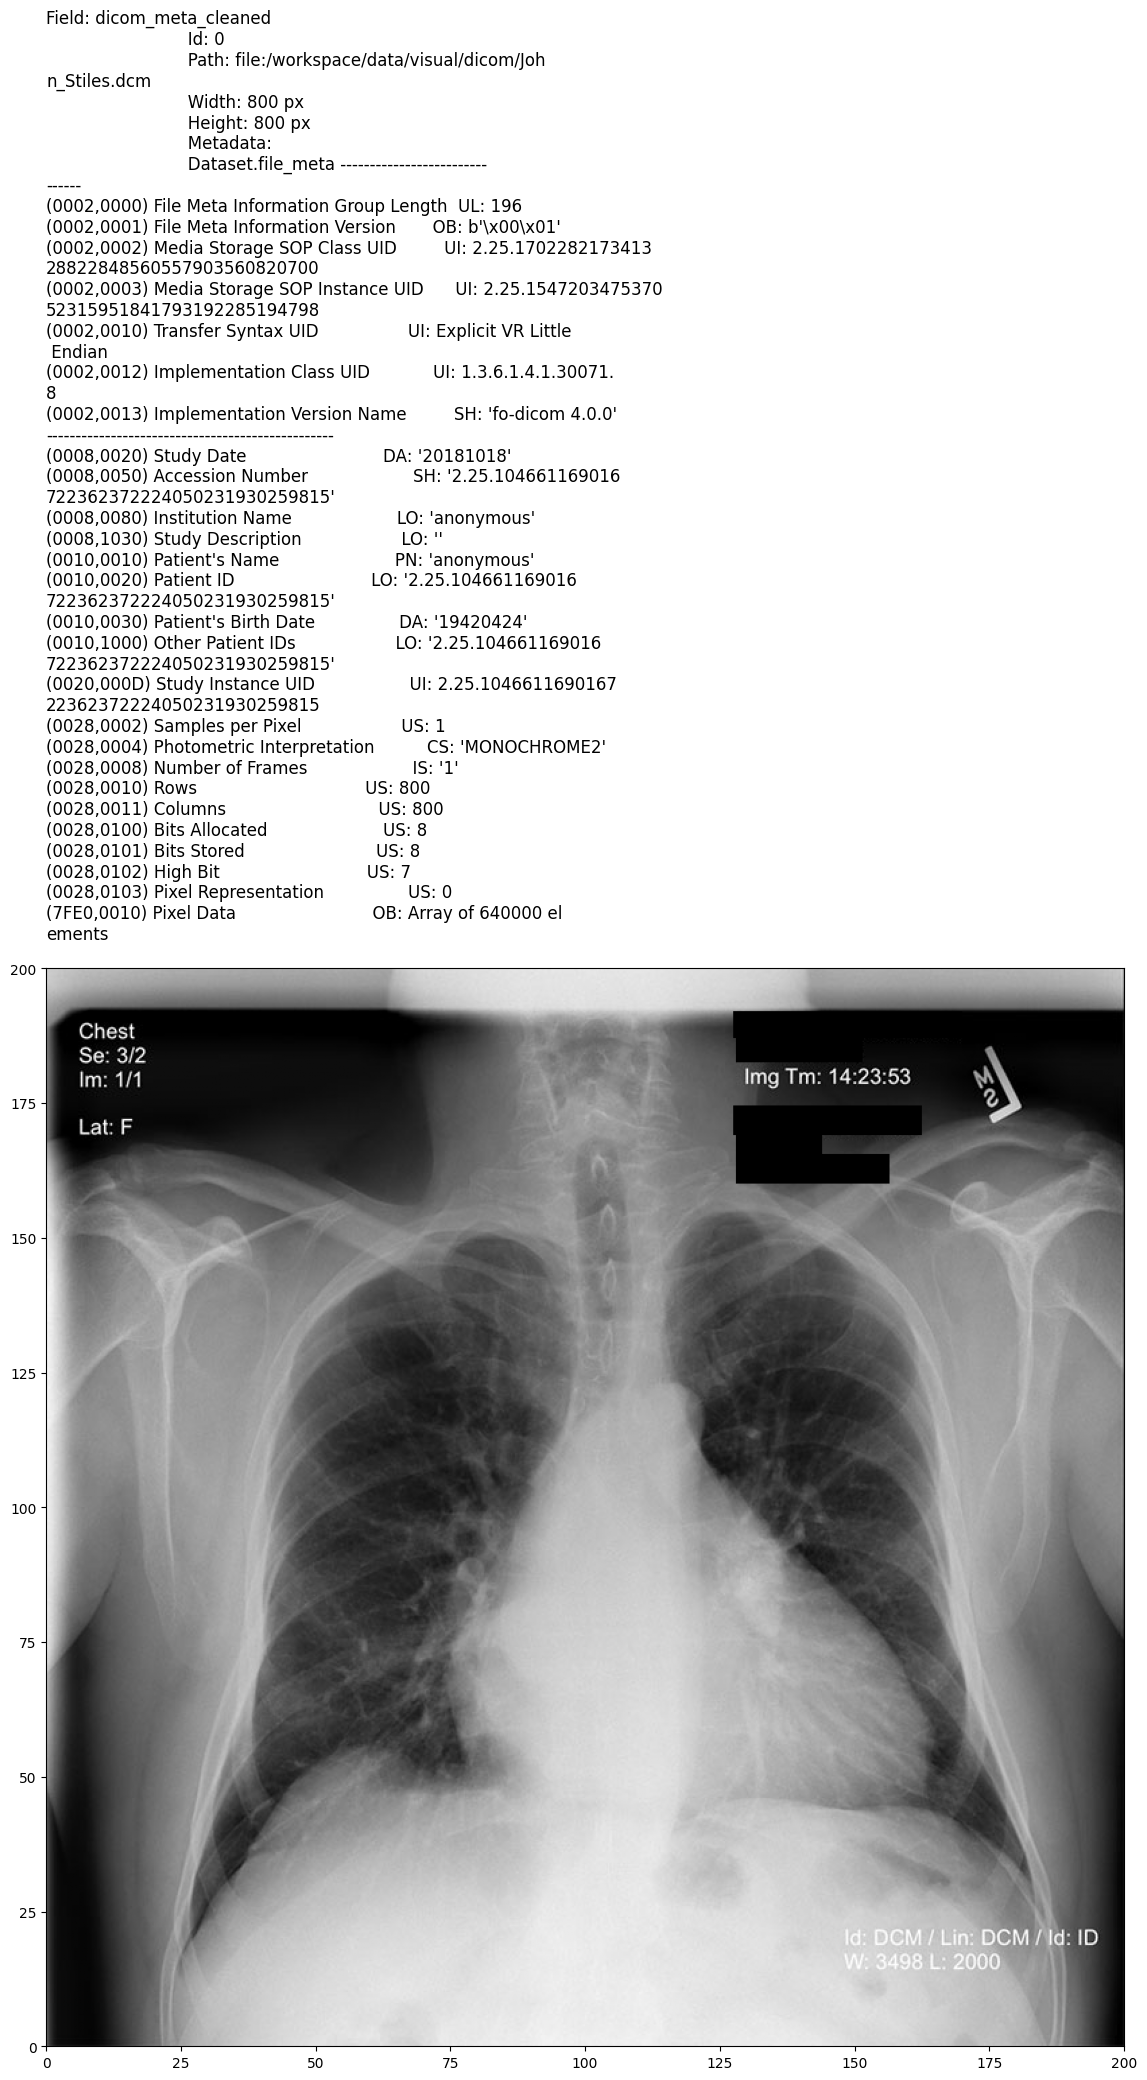

In [21]:
display_dicom(result, "dicom_meta_cleaned")